In [19]:
# Downloaded libraries
from matplotlib import pyplot as plt
import numpy as np
import pynwb

# Own libraries
import main


In [3]:
from scipy.ndimage import filters
def figsmooth(A,sig):
    '''apply Gaussian smoothing to matrix A containing nans with kernel sig
    without propogating nans'''

    # find zero indices to weight the smoothing matrix
    zero_inds = np.where(A == 0)

    # inversely weight zero indices
    One = np.ones(A.shape)
    One[zero_inds] = .001
    A = filters.gaussian_filter(A,sig)
    One = filters.gaussian_filter(One,sig)
    return A/One

In [25]:
fname1 = "sub-F1_ses-20190407T210000_behavior+ophys_small.nwb"
fname2 = "sub-F1_ses-20190416T210000_behavior+ophys_small.nwb"
fname3 = "sub-R1_ses-20190211T210000_behavior+ophys_small.nwb"
fname4 = "sub-R1_ses-20190223T210000_behavior+ophys_small.nwb"
fname5 = "sub-R2_ses-20190219T210000_behavior+ophys_small.nwb"
directory = "data\TestPlitt"

# # F2 Late
# handledFiles = ["sub-F2_ses-20190415T210000_behavior+ophys_small.nwb",\
#                "sub-F2_ses-20190416T210000_behavior+ophys_small.nwb",\
#                "sub-F2_ses-20190417T210000_behavior+ophys_small.nwb"]

# # F5 Late
# handledFiles = ["sub-F5_ses-20190415T210000_behavior+ophys_small.nwb",\
#                "sub-F5_ses-20190416T210000_behavior+ophys_small.nwb",\
#                "sub-F5_ses-20190417T210000_behavior+ophys_small.nwb",\
#                "sub-F5_ses-20190418T210000_behavior+ophys_small.nwb"]

# # R1 Late
# handledFiles = ["sub-R1_ses-20190220T210000_behavior+ophys_small.nwb",\
#                "sub-R1_ses-20190221T210000_behavior+ophys_small.nwb",\
#                "sub-R1_ses-20190222T210000_behavior+ophys_small.nwb",\
#                "sub-R1_ses-20190223T210000_behavior+ophys_small.nwb"]

# # R1 Early
# handledFiles = ["sub-R1_ses-20190211T210000_behavior+ophys_small.nwb",\
#                "sub-R1_ses-20190214T210000_behavior+ophys_small.nwb",\
#                "sub-R1_ses-20190216T210000_behavior+ophys_small.nwb"]

# # These are the files used for FULL RUN 0!!!!!!!!!!
# handledFiles = ["sub-F1_ses-20190407T210000_behavior+ophys_small.nwb",\
#                "sub-F2_ses-20190417T210000_behavior+ophys_small.nwb",\
#                "sub-R1_ses-20190211T210000_behavior+ophys_small.nwb",\
#                "sub-R1_ses-20190223T210000_behavior+ophys_small.nwb"]

# # SHUFFLE RUN 1
# handledFiles = ["sub-F2_ses-20190407T210000_behavior+ophys_small.nwb",\
#                "sub-F5_ses-20190418T210000_behavior+ophys_small.nwb",\
#                "sub-R2_ses-20190209T210000_behavior+ophys_small.nwb",\
#                "sub-R2_ses-20190221T210000_behavior+ophys_small.nwb"]


# # SHUFFLE RUN 2
# handledFiles = ["sub-F2_ses-20190407T210000_behavior+ophys_small.nwb",\
#                "sub-F1_ses-20190416T210000_behavior+ophys_small.nwb",\
#                "sub-R3_ses-20190211T210000_behavior+ophys_small.nwb",\
#                "sub-R3_ses-20190223T210000_behavior+ophys_small.nwb"]


# SHUFFLE RUN 3
handledFiles = ["sub-F5_ses-20190407T210000_behavior+ophys_small.nwb",\
               "sub-F2_ses-20190416T210000_behavior+ophys_small.nwb",\
               "sub-R4_ses-20190824T210000_behavior+ophys_small.nwb",\
               "sub-R4_ses-20190905T210000_behavior+ophys_small.nwb"]

F1early = main.getSessionHandle(fname1, directory)
F1late = main.getSessionHandle(fname2, directory)
R1early = main.getSessionHandle(fname3, directory)
R1late = main.getSessionHandle(fname4, directory)
R2 = main.getSessionHandle(fname5, directory)

In [26]:
nNeurons = {}
deconvTraces = {}
startIndices = {}
baseMorph = {}
position = {}
nTrials = {}

readFiles = [main.getSessionHandle(file, directory) for file in handledFiles]
nFiles = len(readFiles)

for i, file in enumerate(readFiles):
    data = main.dataExtraction(readFiles[i].read())

    # nFrames = data["nFrames"]
    nNeurons[i] = data["nNeurons"]
    deconvTraces[i] = data["deconvTraces"]
    # tstartData = data["tstartData"]
    nTrials[i] = data["nTrials"]
    startIndices[i] = data["startIndices"]
    baseMorph[i] = data["baseMorph"]
    # totalMorph = data["totalMorph"]
    position[i] = data["position"]

### With shuffling analysis

In [5]:
dbs = {}
pbs = {}
shifted_pbs = {}

df = {}
occp = {}

baseMorphList = {i:baseMorph[i][startIndices[i]] for i in range(nFiles)} 

nShuffles = 100

# This will store the mega arrays off all SIs for all shuffles for each handled file
allSIs = {i:[] for i in range(nFiles)}

for iteration in range(nShuffles):
    SIMatrix = {i:np.zeros((nNeurons[i], 5)) for i in range(nFiles)}
    for i in range(nFiles):
        dbs[i], pbs[i] = main.trialize(deconvTraces[i], position[i], startIndices[i])
#         shift_amounts = np.random.rand(nTrials[i])
#         shifted_pbs[i] = [np.roll(row, int(shift*len(row))) for row, shift in zip(pbs[i], shift_amounts)]
        shift_amounts = np.random.rand(nTrials[i], nNeurons[i])
        shifted_dbs = []
        for trial in range(nTrials[i]):
            nFrames = len(dbs[i][trial])
            shuffleIndex = np.tile(np.arange(nFrames), nNeurons[i]).reshape(-1,nFrames)
            shuffleIndex += (nFrames * shift_amounts[trial].reshape(-1, 1)).astype(int)
            shuffleIndex = (shuffleIndex % nFrames).astype(int)
            # shifted_dbs.append(dbs[i][trial][np.arange(nFrames)[:, None], shuffleIndex.T])           
            
            # Fixed shuffling below:
            shifted_dbs.append(dbs[i][trial].T[np.arange(nNeurons[i])[:, None], shuffleIndex].T) 
            
        df[i], occp[i] = main.positionalBin(shifted_dbs, pbs[i])
        del shifted_dbs
 
        for n in range(nNeurons[i]):
            SIMatrix[i][n,:] = main.getSpatialInformation(df[i][:,:,n], occp[i], baseMorphList[i])
        
        allSIs[i].append(SIMatrix[i])

In [244]:
# TESTING AREA FOR REINDEXING TO SHUFFLE EACH NEURON SEPARATELY
TRIALS = 2
FRAMES = 20
NEURONS = 5
myshiftamts = np.random.rand(TRIALS, NEURONS)

sample_trial = (np.random.rand(FRAMES,NEURONS) > 0.65).astype(int)
myshuffind = np.tile(np.arange(FRAMES), NEURONS).reshape(-1,FRAMES)
myshuffind += (FRAMES * myshiftamts[0].reshape(-1,1)).astype(int)
myshuffind = (myshuffind % FRAMES).astype(int)
print(sample_trial.T)
print(sample_trial.T[np.arange(NEURONS)[:,None], myshuffind])


[[0 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0]
 [1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0]
 [0 0 0 1 1 0 0 1 1 1 0 0 1 0 1 0 1 1 1 0]
 [0 0 0 1 1 0 0 1 0 1 0 0 0 1 1 0 0 1 1 0]]
[[0 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1 0 1 1 0]
 [0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1]
 [0 1 1 0 0 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0]
 [0 1 1 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0]]


(array([[ 4., 13., 22., 36., 15.,  7.,  3.,  0.,  0.,  0.],
        [ 1.,  5., 13., 28., 25., 15., 10.,  3.,  0.,  0.],
        [ 4.,  9., 23., 31., 16.,  7.,  5.,  4.,  1.,  0.],
        [ 3., 17., 18., 29., 17.,  7.,  7.,  0.,  2.,  0.],
        [ 0.,  3.,  9., 21., 21., 22., 16.,  3.,  3.,  2.]]),
 array([ 1.77601166,  2.62764024,  3.47926882,  4.3308974 ,  5.18252599,
         6.03415457,  6.88578315,  7.73741173,  8.58904031,  9.44066889,
        10.29229747]),
 <a list of 5 BarContainer objects>)

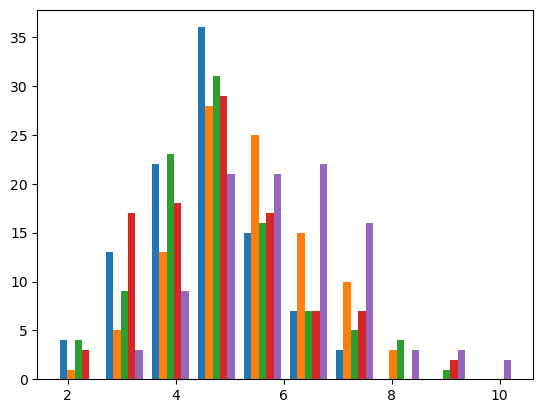

In [55]:

# thresholds = np.percentile(allSIs[1], 95, axis=0)
# plt.hist(allSIs[1][0])
# thresholds
t = np.array(allSIs[1])
plt.hist(t[:,10,])

In [67]:
SIMasks = {i:np.percentile(allSIs[i], 95, axis=0) for i in range(nFiles)}
shuffThreshs = {i:np.mean(mask) for i,mask in enumerate(SIMasks.values())}
# plt.hist(allSIs[1][0])
shuffThreshs
# np.mean(thresholds)
# plt.hist(thresholds)

{0: 4.169904545644902,
 1: 7.330122586398041,
 2: 11.452765556674397,
 3: 7.0102012018163995}

In [7]:
## BE CAREFUL TO CHANGE THIS VARIABLE EVERY TIME
nRun = 0 # IF IN DOUBT CHANGE
# CHANGE CHANGE CHANGE CHANGE CHANGE CHANGE CHANGE CHANGE CHANGE CHANGE
# CHANGE CHANGE CHANGE CHANGE CHANGE CHANGE CHANGE CHANGE CHANGE CHANGE

np.savez(f'finalRun{nRun}.npz', F_early = allSIs[0], F_late = allSIs[1], R_early = allSIs[2]\
                , R_late = allSIs[3])

(array([[418., 628., 140.,  24.,   7.,   3.,   2.,   1.,   0.,   1.],
        [361., 645., 178.,  29.,   5.,   2.,   2.,   1.,   1.,   0.],
        [255., 696., 210.,  41.,  13.,   4.,   3.,   1.,   1.,   0.],
        [263., 702., 206.,  34.,  10.,   2.,   4.,   1.,   2.,   0.],
        [233., 685., 242.,  44.,  12.,   4.,   2.,   1.,   0.,   1.]]),
 array([ 0.1140655 ,  2.80711697,  5.50016843,  8.1932199 , 10.88627136,
        13.57932283, 16.27237429, 18.96542576, 21.65847723, 24.35152869,
        27.04458016]),
 <a list of 5 BarContainer objects>)

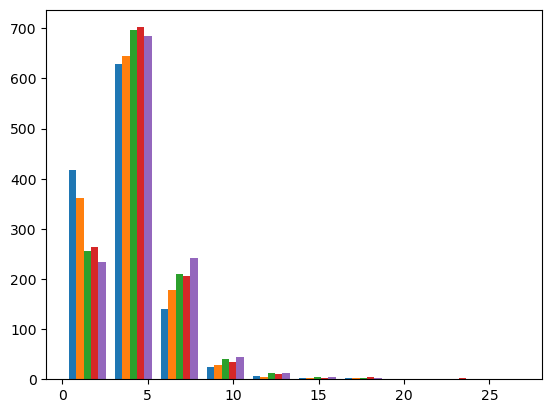

In [6]:
loaded_data = np.load(f'shufflerun1.npz')
np.shape(loaded_data['F_late'])
thresholds = np.percentile(loaded_data['F_late'], 95, axis=0)

plt.hist(thresholds)


In [6]:
import datetime

current_time = datetime.datetime.now()
print("Current date and time:", current_time)

Current date and time: 2023-08-08 16:28:45.083790


### Without shuffling analysis

In [27]:
dbs = {}
pbs = {}
shifted_pbs = {}
df = {}
occp = {}

for i in range(nFiles):
    dbs[i], pbs[i] = main.trialize(deconvTraces[i], position[i], startIndices[i])
    df[i], occp[i] = main.positionalBin(dbs[i], pbs[i])

In [28]:
SIMatrix = {i:np.zeros((nNeurons[i], 5)) for i in range(nFiles)}
baseMorphList = {i:baseMorph[i][startIndices[i]] for i in range(nFiles)} 
 
for sess in range(nFiles):
    for i in range(nNeurons[sess]):
        SIMatrix[sess][i,:] = main.getSpatialInformation(df[sess][:,:,i], occp[sess], baseMorphList[sess])
       

In [31]:
print(f'Place cell proportions using different methods\n')
# # If we are using thresholds as a "mask" SI Matrix
# placeCellPropMask = {i:np.mean(SIMatrix[i] > SIMasks[i])*100 for i in range(nFiles)}

# print(f'from new shuffle, using SIMatrix as mask:\n{placeCellPropMask}')

# # If we are using the simplified threshold metric
# placeCellPropSimp = {i:len(np.where(SIMatrix[i] > thresholds[i])[0])*100 / SIMatrix[i].size for i in range(nFiles)}
# print(f'from new shuffle, using simplified threshold:\n{placeCellPropSimp}')

# # From the old method
# loaded_data = np.load(f'run5.npz')
# fNames = [filename for filename in loaded_data]
# oldSIShuffles = {i:loaded_data[fname] for i, fname in enumerate(fNames)}
# oldSIMasks = {i:np.percentile(SIs, 95, axis=0) for i, SIs in enumerate(oldSIShuffles.values())}

# placeCellPropOldMask = {i:np.mean(SIMatrix[i] > oldSIMasks[i])*100 for i in range(nFiles)}
# print(f'from old shuffle, using SIMatrix as mask:\n{placeCellPropOldMask}')

# From the new, correct method
nloaded_data = np.load(f'shufflerun3.npz')
nfNames = [filename for filename in nloaded_data]
newSIShuffles = {i:nloaded_data[fname] for i, fname in enumerate(nfNames)}
newSIMasks = {i:np.percentile(SIs, 95, axis=0) for i, SIs in enumerate(newSIShuffles.values())}

placeCellPropNewMask = {i:np.mean(SIMatrix[i] > newSIMasks[i])*100 for i in range(nFiles)}
print(f'from newest shuffle, using SIMatrix as mask:\n{placeCellPropNewMask}')
    


Place cell proportions using different methods

from newest shuffle, using SIMatrix as mask:
{0: 19.182915506035283, 1: 26.09200968523002, 2: 23.36, 3: 49.26078028747433}


### End of uncommon

In [112]:
# Using the original "blind" threshold to determine place cell significance
thresholds = {i:np.percentile(SIMatrix[i], 95) for i in range(nFiles)}
# Using the significance value calculated from shuffling analysis

# print(thresholds)
placeCellInds = {sess:{} for sess in range(nFiles)}
for sess in range(nFiles):
    for i, key in enumerate(main.baseMorphValues):
# Blind threshold method
#         placeCellInds[sess][key] = np.where(SIMatrix[sess][:,i] > thresholds[sess])[0]
# 
        placeCellInds[sess][key] = np.where(SIMatrix[sess][:,i] > oldSIMasks[sess][:,i])[0]
        

In [138]:
np.where(SIMatrix[0][:,0] > oldSIMasks[0][:,0])[0]


array([  0,   4,   9,  10,  12,  15,  18,  19,  21,  22,  25,  31,  32,
        33,  36,  37,  39,  42,  46,  51,  55,  57,  59,  60,  67,  69,
        73,  75,  82,  83,  84,  91,  96,  98, 100, 101, 102, 104, 107,
       110, 113, 120, 128, 130, 131, 147, 150, 155, 159, 161, 163, 171,
       173, 174, 175, 177, 178, 180, 183, 193, 196, 205, 207, 210, 211,
       214, 219, 226, 229, 232, 233, 237, 239, 240, 241, 242, 244, 245,
       255, 256, 257, 261, 264, 271, 272, 276, 282, 283, 284, 301, 304,
       311, 313, 320, 329, 332, 333, 336, 339, 346, 353, 354, 364, 365,
       375, 378, 382, 384, 385, 390, 404, 406, 408, 410, 413, 419, 422,
       427, 445, 458, 460, 463, 466, 468, 470, 475, 482, 491, 492, 499,
       506, 512, 520, 521, 526, 528, 534, 539, 555, 568, 575, 594, 595,
       612, 617, 618, 627, 638, 642, 646, 654, 660, 668, 671, 695, 715,
       725, 734, 746, 757, 774, 782, 793, 810, 818, 822, 830, 835, 841,
       855, 862, 868, 870, 882, 891, 894, 896, 897, 935, 944, 97

In [122]:
df_placeCells = {}
baseIndices = {}
avgActivity = {}

for sess in range(nFiles):
    # extracts the sub-dataframes for the place cells for each basemorph value (all trials)
    df_placeCells[sess] = {key:df[sess][:,:,placeCellInds[sess][key]] for key in main.baseMorphValues}

    # gets the indices of the trials at each base morph value
    baseIndices[sess] = {i:np.where(baseMorphList[sess] == i)[0] for i in main.baseMorphValues}

    avgActivity[sess] = {key:{} for key in main.baseMorphValues}
    for cells in main.baseMorphValues:
        for trials in main.baseMorphValues:
            bInds = baseIndices[sess][trials]
            num = np.sum(df_placeCells[sess][cells][bInds], axis = 0)
            den = np.sum(occp[sess][bInds], axis = 0).reshape(-1,1)
            avgActivity[sess][cells][trials] = num / den


In [123]:
avgActMat = {sess:np.empty((5,), dtype=object) for sess in range(nFiles)}
norms = {}

for sess in range(nFiles):
    for i, row in enumerate(main.baseMorphValues):
        for j, col in enumerate(main.baseMorphValues):
            if j == 0:
                avgActMat[sess][i] = avgActivity[sess][row][col]
            else:
                avgActMat[sess][i] = np.vstack((avgActMat[sess][i], avgActivity[sess][row][col]))

    norms[sess] = [np.max(mat, axis=0) for mat in avgActMat[sess]]



### Calculation of place cell metrics

##### Testing area

In [179]:
allPlaceCellsNum = {}
placeCellNum = {}
placeCellPct = {}

for sess in range(nFiles):
    print(f"\nFor session {sess}:")
    allPlaceCellsNum[sess] = len(np.unique(np.where(SIMatrix[sess] > thresholds[sess])[0]))
    print("The total number of ROIs that are place cells for at least one base morph is:", allPlaceCellsNum[sess], "out of", nNeurons[sess], "cells")

    placeCellNum[sess] = {inds:len(placeCellInds[sess][inds]) for inds in placeCellInds[sess]}
    placeCellPct[sess] = {inds:len(placeCellInds[sess][inds])*100/nNeurons[sess] for inds in placeCellInds[sess]}

    for base in main.baseMorphValues:
        print(f"For base morph {base}:\t {placeCellNum[sess][base]} place cells, \t {placeCellPct[sess][base]:.2f}% of all ROIs")
    
# print(placeCellNum)
# print(placeCellPct)


For session 0:
The total number of ROIs that are place cells for at least one base morph is: 358 out of 2066 cells
For base morph 0.0:	 56 place cells, 	 2.71% of all ROIs
For base morph 0.25:	 148 place cells, 	 7.16% of all ROIs
For base morph 0.5:	 141 place cells, 	 6.82% of all ROIs
For base morph 0.75:	 132 place cells, 	 6.39% of all ROIs
For base morph 1.0:	 40 place cells, 	 1.94% of all ROIs

For session 1:
The total number of ROIs that are place cells for at least one base morph is: 380 out of 2066 cells
For base morph 0.0:	 31 place cells, 	 1.50% of all ROIs
For base morph 0.25:	 179 place cells, 	 8.66% of all ROIs
For base morph 0.5:	 150 place cells, 	 7.26% of all ROIs
For base morph 0.75:	 126 place cells, 	 6.10% of all ROIs
For base morph 1.0:	 31 place cells, 	 1.50% of all ROIs

For session 2:
The total number of ROIs that are place cells for at least one base morph is: 349 out of 2074 cells
For base morph 0.0:	 28 place cells, 	 1.35% of all ROIs
For base morph 

In [124]:
peaks = {}
rewardPeaks = {}

for sess in range(nFiles):
    peaks[sess] = {base:np.argmax(avgActivity[sess][base][base],axis=0) for base in main.baseMorphValues}
    rewardPeaks[sess] = {base:len(np.where((peaks[sess][base] > 25) & (peaks[sess][base] < 40))[0]) for base in main.baseMorphValues}
    # rewardPeaks = {base:len(np.where((peaks[base] > 25))[0]) for base in main.baseMorphValues}

    print(f"\nFor session {sess}:")
    for base in main.baseMorphValues:
#         print(f"For base morph {base}:\t {rewardPeaks[sess][base]} cells tuned for reward region")
        print(f"For base morph {base}:\t {100*rewardPeaks[sess][base]/placeCellNum[sess][base]:.2f} % cells tuned for reward region ({rewardPeaks[sess][base]} cells)")    


For session 0:


NameError: name 'placeCellNum' is not defined

In [125]:
# NEEDED: aggregate average activity peaks. we will have per baseMorph, one set of peaks.
# This code aggregates the location of the activity peaks from all sessions. We are only taking the avgActivity of place cells
# in trials that match the baseMorph they are considered a place cell in.

allPeaks = {}
for base in main.baseMorphValues:
    for sess in range(nFiles):
        if sess == 0:
            allPeaks[base] = np.argmax(avgActivity[sess][base][base],axis=0)
        else:
            allPeaks[base] = np.hstack((allPeaks[base], np.argmax(avgActivity[sess][base][base],axis=0)))        
                   
    

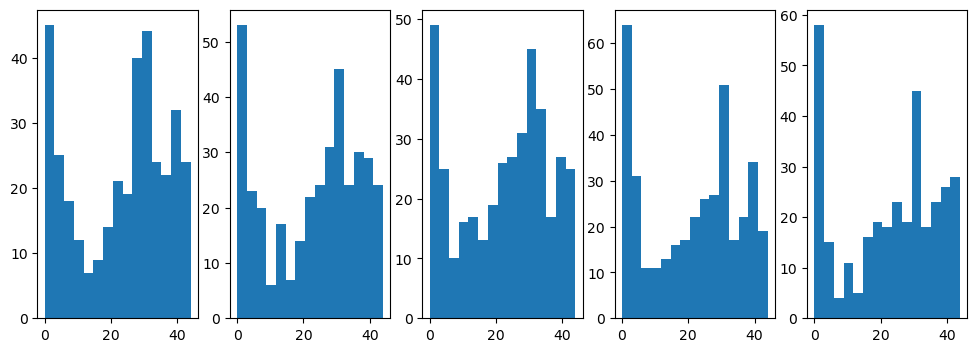

In [126]:
fig, ax = plt.subplots(1,5, figsize=(12,4))

## This section of code was for plotting the histogram of peaks corresponding to one session only
# for i, base in enumerate(main.baseMorphValues):
#     ax[i].hist(np.argmax(avgActivity[1][base][base],axis=0), bins=10)

# This handles the aggregated peaks and plots the aggregated historgram
for i, base in enumerate(main.baseMorphValues):
    ax[i].hist(allPeaks[base], bins=15)
    

In [183]:
# plt.plot(np.mean(occp[sess], axis=0))
# np.shape(np.sum(np.sum(occp[sess], axis=0).reshape(-1,3), axis=1)//3)

# counts = np.histogram(allPeaks[0], bins=15)[0]

cellCounts = np.histogram(np.argmax(avgActivity[0][0][0],axis=0),bins=15)[0]
binnedPos = np.mean(np.mean(occp[0], axis=0).reshape(-1,3), axis=1)

print(np.shape(cellCounts))
print(np.shape(binnedPos))
print(cellCounts)

(15,)
(15,)
[3 3 1 3 3 0 4 6 0 6 1 5 4 9 8]


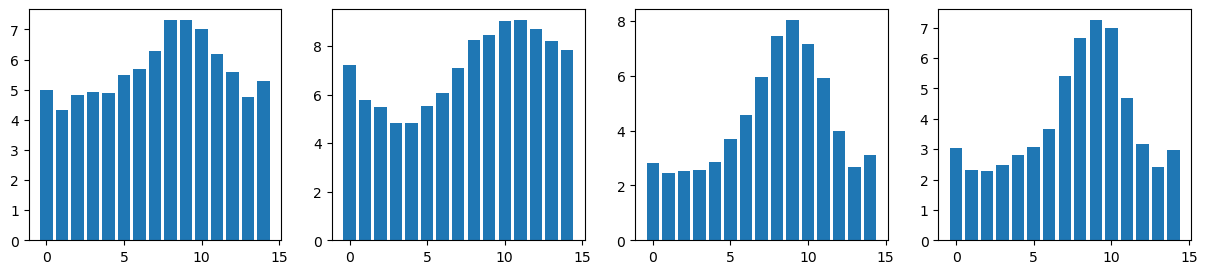

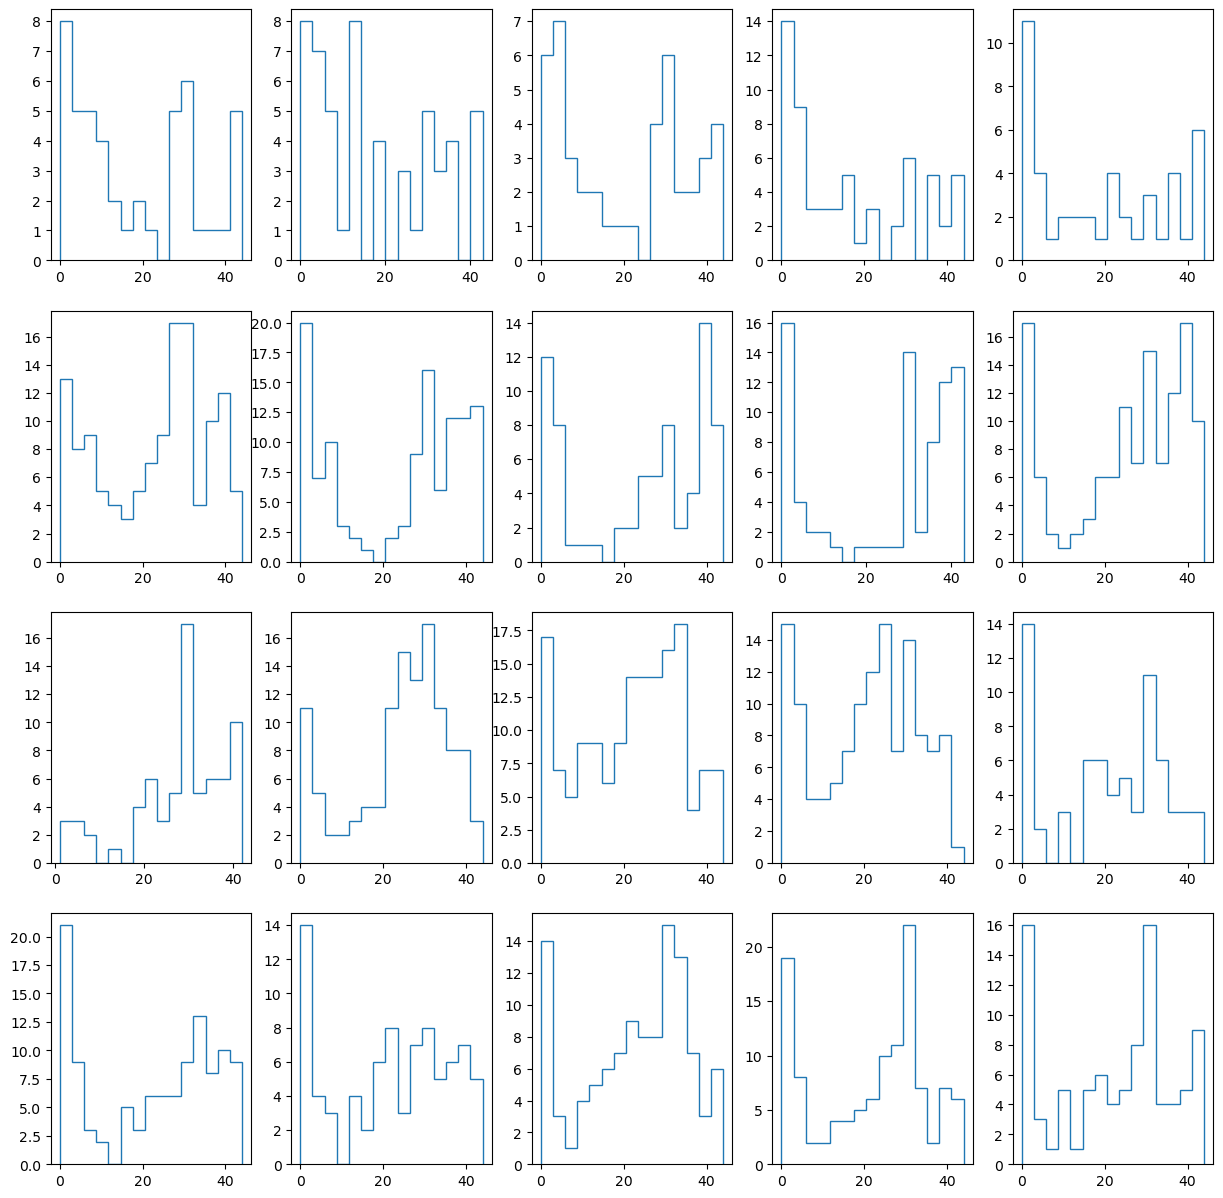

In [127]:
# Plotting average occupancy across trials for each session
fig, ax = plt.subplots(1,nFiles, figsize=(15,3))

for sess in range(nFiles):
    toPlot = np.mean(np.mean(occp[sess], axis=0).reshape(-1,3), axis=1) # inner reshape and mean is to discretoze the array into 15 bins
    ax[sess].bar(range(15),toPlot)
#     ax[sess].plot(toPlot)
#     ax[sess].plot(np.sum(occp[sess], axis=0))


# Plotting for every session, for every base morph, the place cell peak activity location (where the place cell is tuned for)
fig, ax = plt.subplots(4,5, figsize=(15,15))

for sess in range(nFiles):
    for i, base in enumerate(main.baseMorphValues):
        ax[sess][i].hist(np.argmax(avgActivity[sess][base][base],axis=0),bins=15, histtype='step')
        


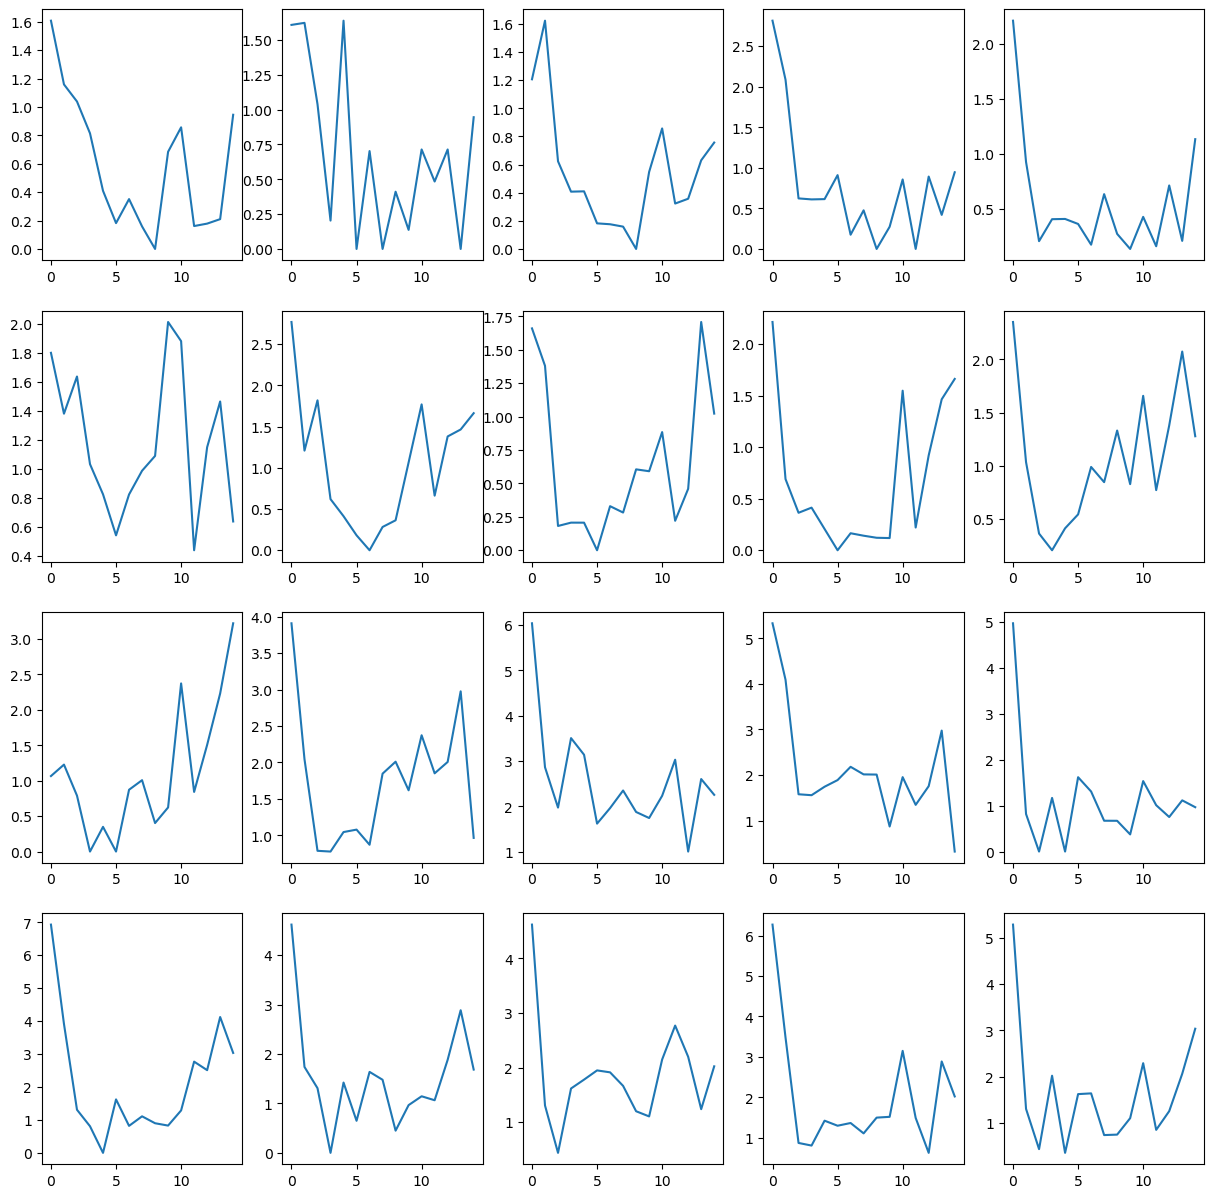

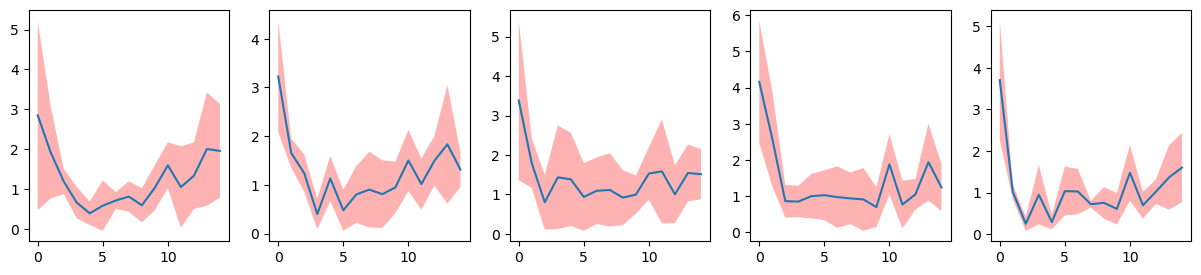

In [128]:
# Plotting the cell count normalized by the average occupancy for every session (for all basemorphs)
fig, ax = plt.subplots(nFiles,len(main.baseMorphValues), figsize=(15,15))

avgcellToOccpR = {}
for sess in range(nFiles):
    for i, base in enumerate(main.baseMorphValues):
        cellCounts = np.histogram(np.argmax(avgActivity[sess][base][base],axis=0),bins=15)[0]
        binnedPos = np.mean(np.mean(occp[sess], axis=0).reshape(-1,3), axis=1)
        ax[sess][i].plot(cellCounts/binnedPos)
        if sess == 0:
            avgcellToOccpR[base] = cellCounts/binnedPos
        else:
            avgcellToOccpR[base] = np.vstack((avgcellToOccpR[base], cellCounts/binnedPos))

# Plotting the average normalized cell count across sessions
fig, ax = plt.subplots(1,5, figsize=(15,3))
for i, base in enumerate(main.baseMorphValues):
    means = np.mean(avgcellToOccpR[base],axis=0)
    stds = np.std(avgcellToOccpR[base],axis=0)
    ax[i].plot(range(15),means)
    ax[i].fill_between(range(15),means-stds,means+stds,alpha=0.3,facecolor='red')

### Plotting of rose-gold plot

## Plotting for MULTIPLE SESSIONS

In [130]:
# Stack for 5x5 grid
# This code stacks the 5x5 grid of calculated average activity for each session into one aggregated 5x5 grid of average activity
# It also handles the stacking of the normalization factors calculated for each session (each session has 5, one for each baseMorph) 

allCellsToPlot = {key:{} for key in main.baseMorphValues}
allNorms = {}
for sess in range(nFiles):
    for row, cells in enumerate(main.baseMorphValues):
        if sess == 0:
            allNorms[row] = norms[sess][row]
        else:
            allNorms[row] = np.hstack((allNorms[row], norms[sess][row]))
        for col, trials in enumerate(main.baseMorphValues):
            if sess == 0:
                allCellsToPlot[cells][trials] = avgActivity[sess][cells][trials]
            else:
                allCellsToPlot[cells][trials] = np.hstack((allCellsToPlot[cells][trials], avgActivity[sess][cells][trials]))
        

C:\Users\tarek\AppData\Local\Temp\ipykernel_7564\2643713151.py:12: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  A = filters.gaussian_filter(A,sig)
C:\Users\tarek\AppData\Local\Temp\ipykernel_7564\2643713151.py:13: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  One = filters.gaussian_filter(One,sig)


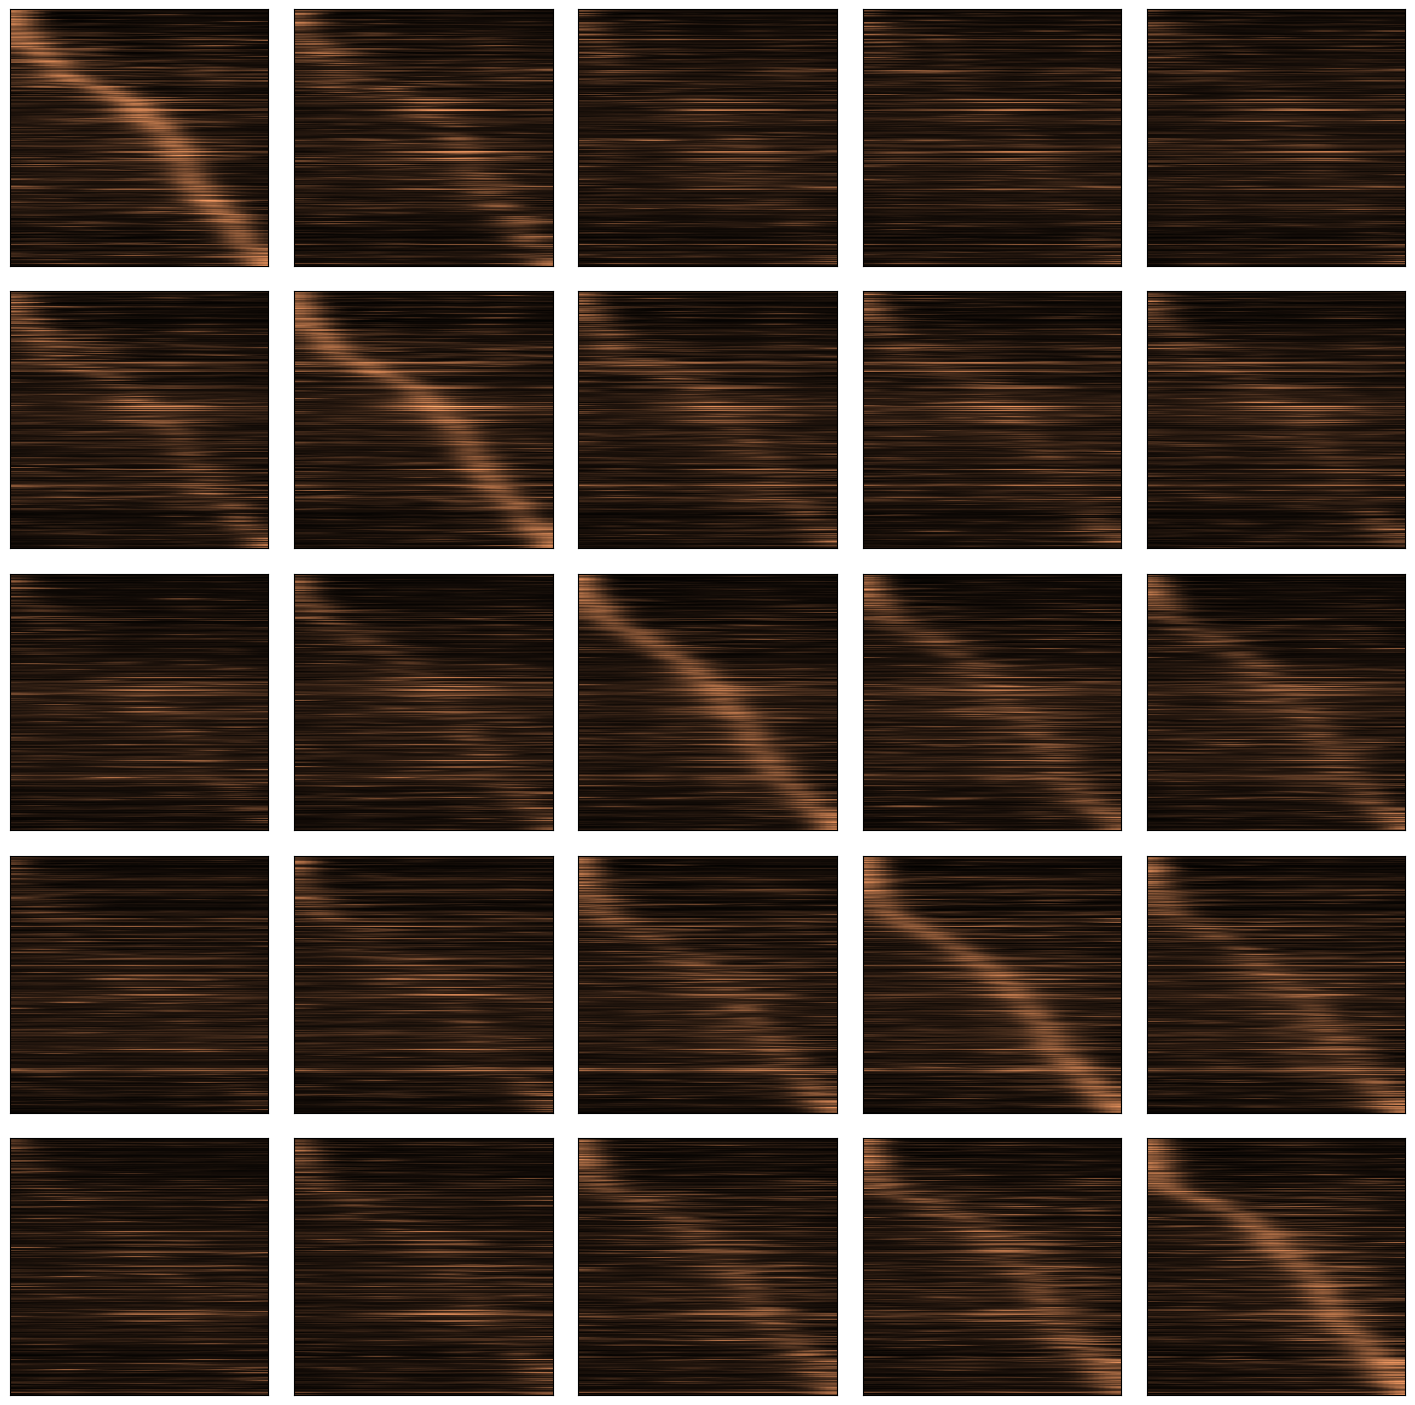

In [131]:
fig, ax = plt.subplots(5,5, figsize=(18,18))

for row, cells in enumerate(main.baseMorphValues):
    for col, trials in enumerate(main.baseMorphValues):
        cellsToPlot = np.transpose(allCellsToPlot[cells][trials][:,np.argsort(np.argmax(allCellsToPlot[cells][cells],axis=0))])
        newNorms = allNorms[row][np.argsort(np.argmax(allCellsToPlot[cells][cells],axis=0))]
        ax[row, col].imshow(figsmooth(cellsToPlot/newNorms.reshape(-1,1),[0,2.5]),cmap='copper', vmin = 0, vmax=0.9, aspect="auto")
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)        
plt.show()

## Plotting for a SINGLE SESSION

C:\Users\tarek\AppData\Local\Temp\ipykernel_7564\2643713151.py:12: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  A = filters.gaussian_filter(A,sig)
C:\Users\tarek\AppData\Local\Temp\ipykernel_7564\2643713151.py:13: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  One = filters.gaussian_filter(One,sig)


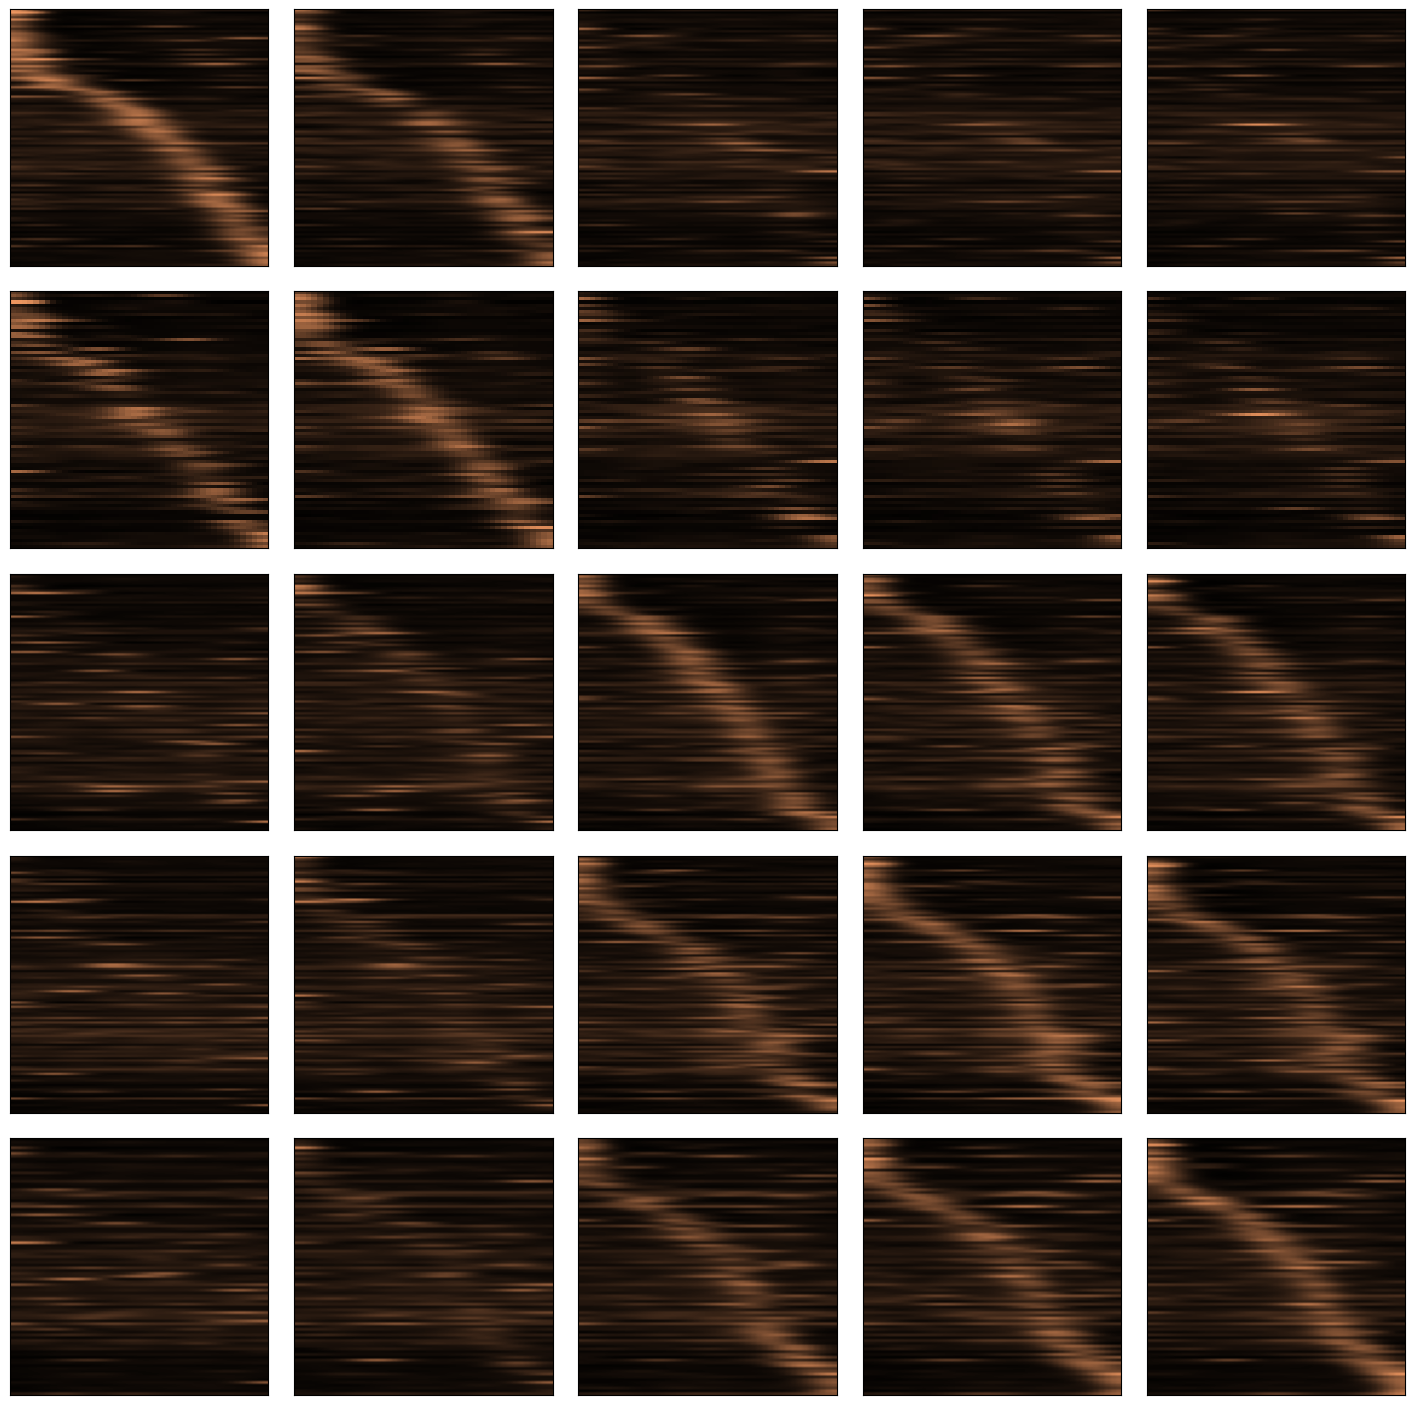

In [136]:
localsess = 3
fig, ax = plt.subplots(5,5, figsize=(18,18))

for row, cells in enumerate(main.baseMorphValues):
    for col, trials in enumerate(main.baseMorphValues):
        cellsToPlot = np.transpose(avgActivity[localsess][cells][trials][:,np.argsort(np.argmax(avgActivity[localsess][cells][cells],axis=0))])
#         newNorms = np.max(cellsToPlot, axis = 1).reshape(-1,1)
#         newNorms = np.max(np.transpose(avgActivity[cells][cells][:,np.argsort(np.argmax(avgActivity[cells][cells],axis=0))]), axis = 1).reshape(-1,1)
        newNorms = norms[localsess][row][np.argsort(np.argmax(avgActivity[localsess][cells][cells],axis=0))]
        ax[row, col].imshow(figsmooth(cellsToPlot/newNorms.reshape(-1,1),[0,3]),cmap='copper', vmin = 0, vmax=0.9, aspect="auto")
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)        
plt.show()

In [152]:
# arr = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
arr = pbs[0]
shift_amounts = np.random.randint(0,500,size=(120,))

# for row, shift in zip(arr, shift_amounts):
#     print(np.shape(row))
#     print(shift)
shifted_arr = [np.roll(row, shift) for row, shift in zip(arr, shift_amounts)]
# np.shape(dbs[0][0])

print(arr[0])
print(shifted_arr[0])

[  0.01160411   0.04057049   0.06553918   0.08196202   0.09691628
   0.11513012   0.13239399   0.15508769   0.17653687   0.19884386
   0.21886364   0.23582905   0.25774774   0.28020578   0.2999296
   0.31970615   0.32818648   0.33878391   0.34508414   0.35957391
   0.37454951   0.39184961   0.41044017   0.43432036   0.46558455
   0.4899067    0.53050747   0.55974238   0.59074257   0.62404162
   0.65639835   0.69124373   0.72557605   0.75343565   0.79150953
   0.81958015   0.85211918   0.88021074   0.91196497   0.94739474
   0.97817713   1.01136957   1.03619614   1.05363612   1.07185676
   1.08402754   1.09676086   1.11333363   1.13319194   1.15418362
   1.18055662   1.20586396   1.23441994   1.26196219   1.29186305
   1.32137065   1.3529542    1.38129126   1.41451642   1.43860351
   1.47537729   1.50987183   1.54253378   1.57372062   1.60411659
   1.63348866   1.66512181   1.69297915   1.72818319   1.7588898
   1.78905211   1.82314318   1.84263411   1.86230726   1.88225279
   1.8965612